<a href="https://colab.research.google.com/github/YugantGotmare/Deep_learning_project/blob/main/FakevsReal_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces

hardfakevsrealfaces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/hardfakevsrealfaces.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
def read_and_preprocess(img_path, IMAGE_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img, dtype='float32')
    img = img / 255
    return img

In [ ]:
labels = ['real', 'fake']

X = []
y = []

image_path = '/content/Data/'

In [ ]:
for folder in os.scandir(image_path):
    if folder.is_dir():  # Check if the entry is a directory
        for entry in os.scandir(folder.path):
            if entry.is_file():  # Check if the entry is a file
                X.append(read_and_preprocess(entry.path, IMAGE_SIZE))

                if folder.name[0] == 'r':
                    y.append(0)  # real
                else:
                    y.append(1)  # fake

In [ ]:
X = np.array(X)
X.shape

(1289, 128, 128, 3)

In [ ]:
y = np.array(y)
y.shape

(1289,)

<BarContainer object of 2 artists>

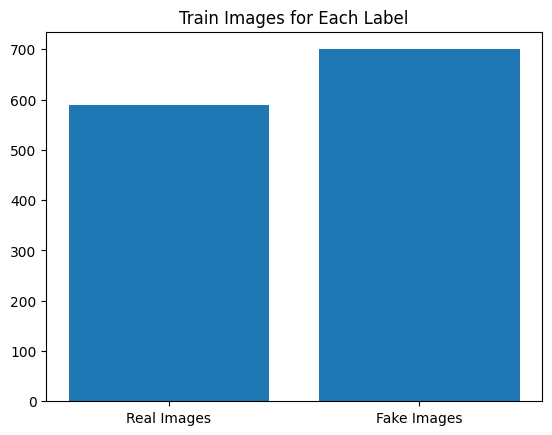

In [ ]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

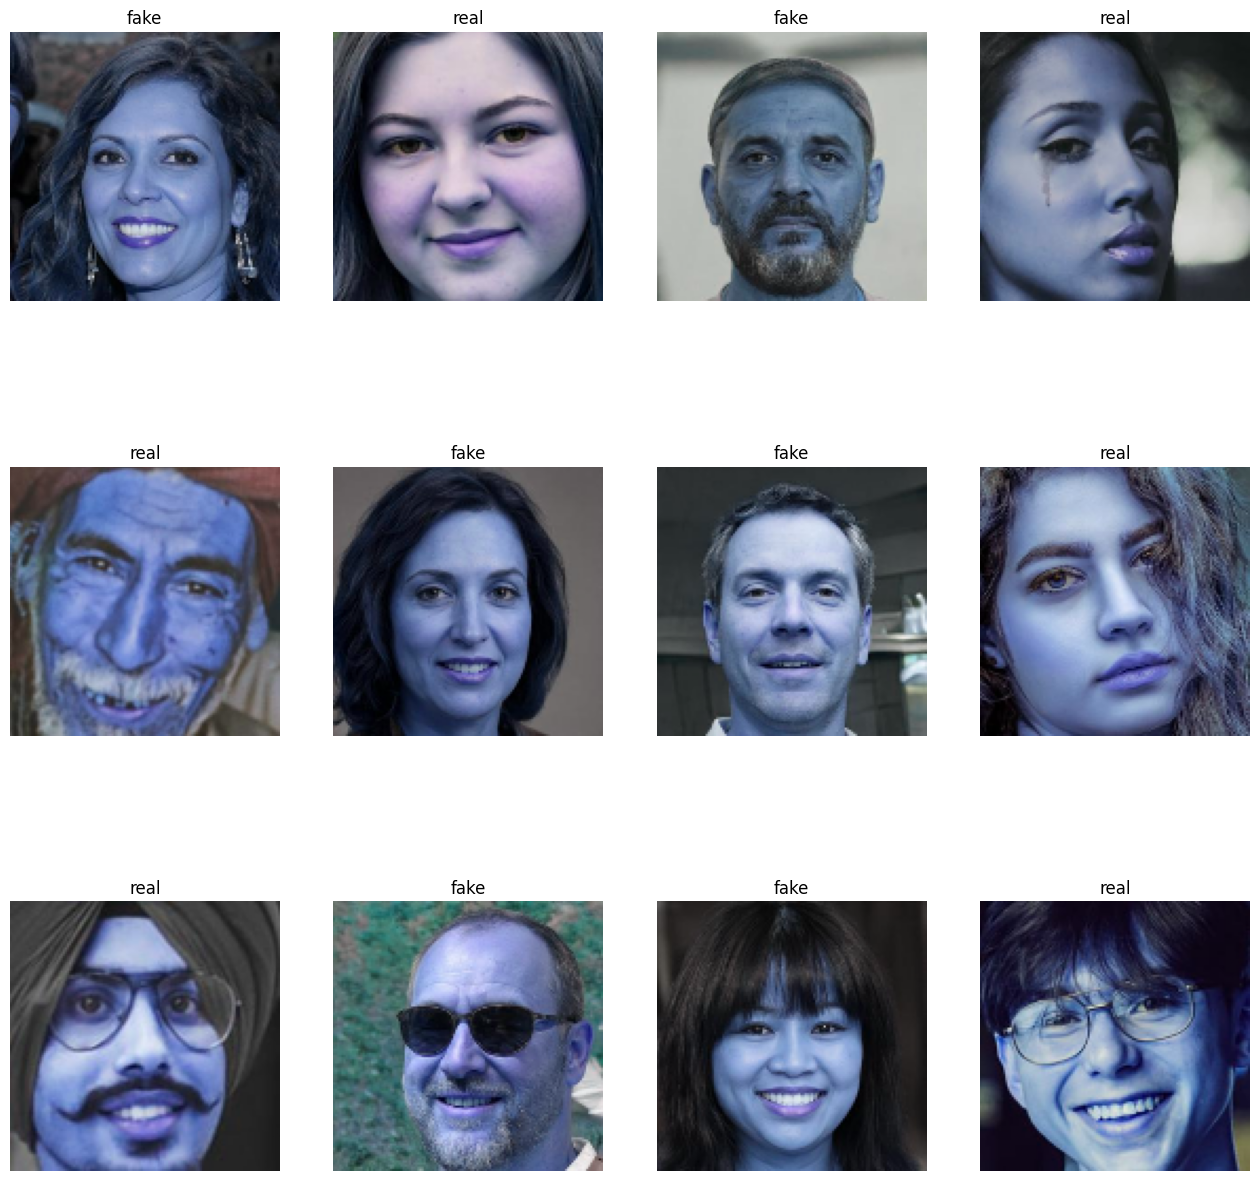

In [ ]:
import random

plt.figure(figsize=(16,16))

for i in range(12):
  ax = plt.subplot(3, 4, i+1)
  plt.axis("off")
  img = random.randint(0, 1289)
  plt.imshow(X[img])
  plt.title(labels[y[img]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=123)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val,
                                                  test_size=0.5,
                                                  shuffle=True,
                                                  stratify=y_val,
                                                  random_state=123)

In [ ]:
X_train.shape

(1031, 128, 128, 3)

In [ ]:
X_val.shape

(129, 128, 128, 3)

In [ ]:
X_test.shape

(129, 128, 128, 3)

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization

    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        6

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5121
Epoch 1: val_loss improved from inf to 0.68790, saving model to fakevsreal_weights.h5
33/33 [==============================] - 10s 48ms/step - loss: 0.6938 - accuracy: 0.5121 - val_loss: 0.6879 - val_accuracy: 0.5426
Epoch 2/100
 5/33 [===>..........................] - ETA: 0s - loss: 0.6784 - accuracy: 0.5688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/33 [============================>.] - ETA: 0s - loss: 0.6783 - accuracy: 0.5449
Epoch 2: val_loss improved from 0.68790 to 0.65446, saving model to fakevsreal_weights.h5
33/33 [==============================] - 1s 20ms/step - loss: 0.6780 - accuracy: 0.5441 - val_loss: 0.6545 - val_accuracy: 0.6512
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.6906
Epoch 3: val_loss improved from 0.65446 to 0.45576, saving model to fakevsreal_weights.h5
33/33 [==============================] - 1s 19ms/step - loss: 0.5968 - accuracy: 0.6906 - val_loss: 0.4558 - val_accuracy: 0.8295
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8965
Epoch 4: val_loss improved from 0.45576 to 0.07786, saving model to fakevsreal_weights.h5
33/33 [==============================] - 1s 20ms/step - loss: 0.2952 - accuracy: 0.8962 - val_loss: 0.0779 - val_accuracy: 0.9767
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss

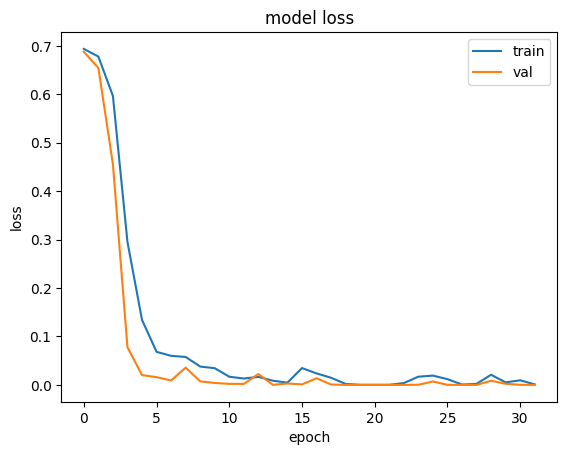

In [ ]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

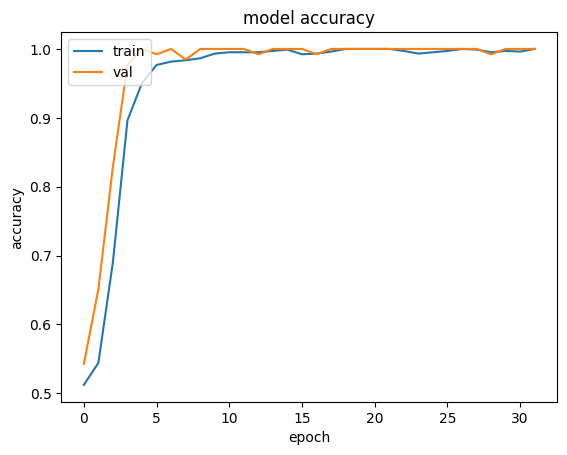

In [ ]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.9922480620155039

<Axes: >

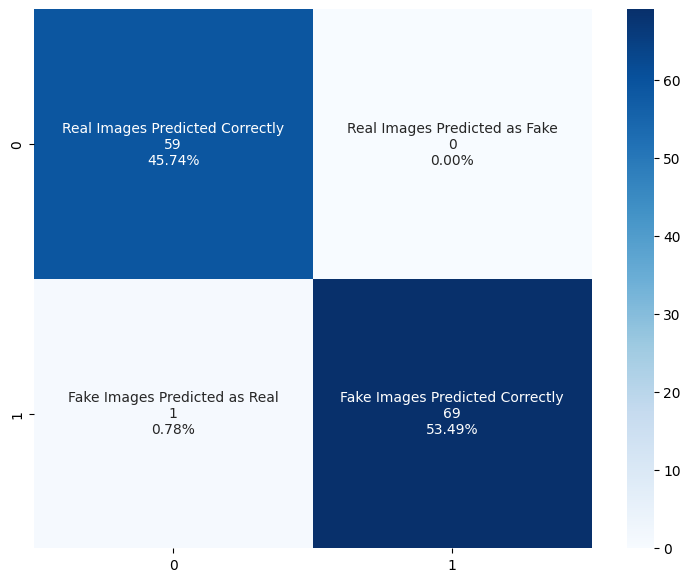

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.99      0.99        70

    accuracy                           0.99       129
   macro avg       0.99      0.99      0.99       129
weighted avg       0.99      0.99      0.99       129

